#Downloading and Preparing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

 98% 350M/358M [00:03<00:00, 88.3MB/s]
100% 358M/358M [00:04<00:00, 93.3MB/s]


In [ ]:
!unzip data-science-bowl-2018.zip -d /content/data-science-bowl-2018

Archive:  data-science-bowl-2018.zip
  inflating: /content/data-science-bowl-2018/stage1_sample_submission.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_solution.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_test.zip  
  inflating: /content/data-science-bowl-2018/stage1_train.zip  
  inflating: /content/data-science-bowl-2018/stage1_train_labels.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_sample_submission_final.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_test_final.zip  


#Importing the Necessaries Libraries

In [ ]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate, Lambda, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Extracting Training and Test Data

In [ ]:
with zipfile.ZipFile('/content/data-science-bowl-2018/stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data-science-bowl-2018/train')

with zipfile.ZipFile('/content/data-science-bowl-2018/stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data-science-bowl-2018/test')

#Loading and Preprocessing Data

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
def load_data(path, train=True):
    ids = next(os.walk(path))[1]
    data = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    masks = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    for i, id_ in enumerate(ids):
        img_path = os.path.join(path, id_, 'images', id_ + '.png')
        mask_path = os.path.join(path, id_, 'masks')

        img = resize(imread(img_path)[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        img = img / 255.0
        data[i] = img

        if train:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask_file in next(os.walk(mask_path))[2]:
                mask_ = imread(os.path.join(mask_path, mask_file))
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            masks[i] = mask

    return data, masks

In [ ]:
X_train, Y_train = load_data('/content/data-science-bowl-2018/train')
X_test, Y_test = load_data('/content/data-science-bowl-2018/test', train=False)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (603, 128, 128, 3)
Y_train shape: (603, 128, 128, 1)
X_val shape: (67, 128, 128, 3)
Y_val shape: (67, 128, 128, 1)
X_test shape: (65, 128, 128, 3)
Y_test shape: (65, 128, 128, 1)


#Displaying Images and Masks

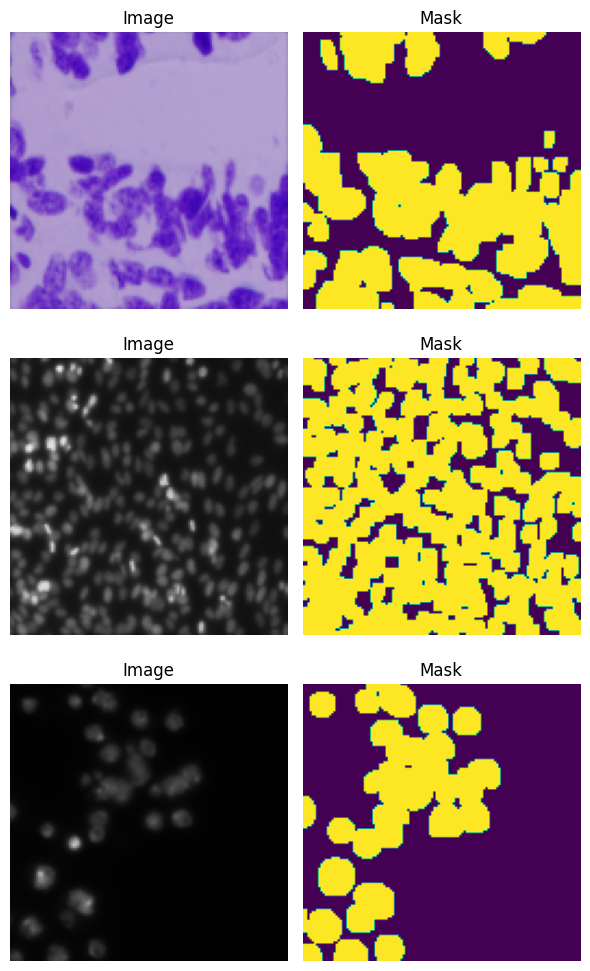

In [ ]:
def display_image(images, masks, num_samples=3, figsize=(10, 10)):
    idx = random.sample(range(len(images)), num_samples)

    plt.figure(figsize=figsize)

    for i, j in enumerate(idx):
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[j])
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(np.squeeze(masks[j]))
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_image(X_train, Y_train, num_samples=3, figsize=(6, 10))

#U-Net Model

##Defining the U-Net Architecture

In [ ]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = Concatenate()([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = Concatenate()([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = Concatenate()([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = Concatenate()([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

##Setting Up Callbacks for Model Training

In [ ]:
checkpoint = ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(patience = 5, monitor = 'val_loss')
tensorboard = TensorBoard(log_dir = 'logs')

callbacks = [checkpoint , early_stopping , tensorboard]

##Training the U-Net Model

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    validation_data= (X_val, Y_val),
    batch_size = 16,
    epochs = 50,
    callbacks = callbacks)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7495
Epoch 1: val_loss improved from inf to 0.45435, saving model to model.h5
38/38 [==============================] - 124s 3s/step - loss: 0.5856 - accuracy: 0.7495 - val_loss: 0.4544 - val_accuracy: 0.7663
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8785
Epoch 2: val_loss improved from 0.45435 to 0.25777, saving model to model.h5
38/38 [==============================] - 109s 3s/step - loss: 0.2920 - accuracy: 0.8785 - val_loss: 0.2578 - val_accuracy: 0.9020
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9289
Epoch 3: val_loss improved from 0.25777 to 0.22067, saving model to model.h5
38/38 [==============================] - 109s 3s/step - loss: 0.1848 - accuracy: 0.9289 - val_loss: 0.2207 - val_accuracy: 0.9058
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9440
Epoch 4

##Plotting Training History: Accuracy and Loss

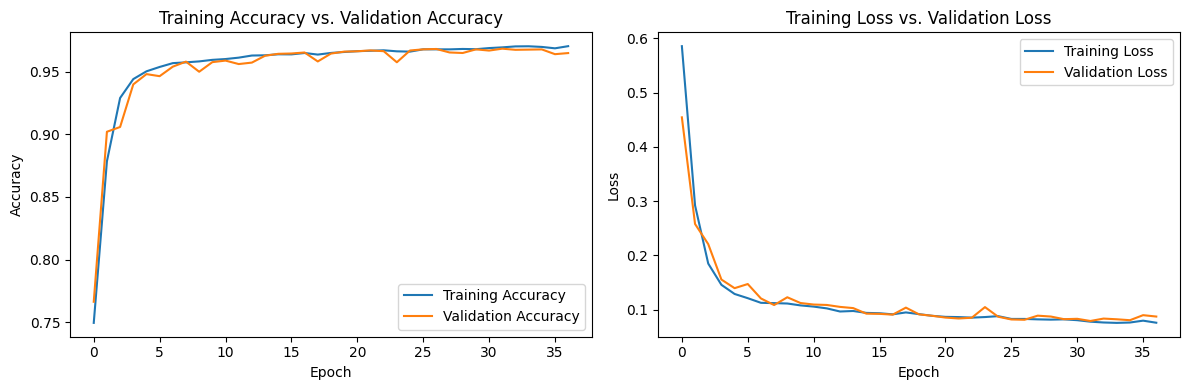

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

##Displaying Images, Ground Truth Masks, and Predicted Masks

In [ ]:
train_preds = ((model.predict(X_train, verbose = 1))>0.5).astype(np.uint8)
val_preds = ((model.predict(X_val, verbose = 1))>0.5).astype(np.uint8)
test_preds = ((model.predict(X_test, verbose = 1))>0.5).astype(np.uint8)

3/3 [==============================] - 3s 823ms/step


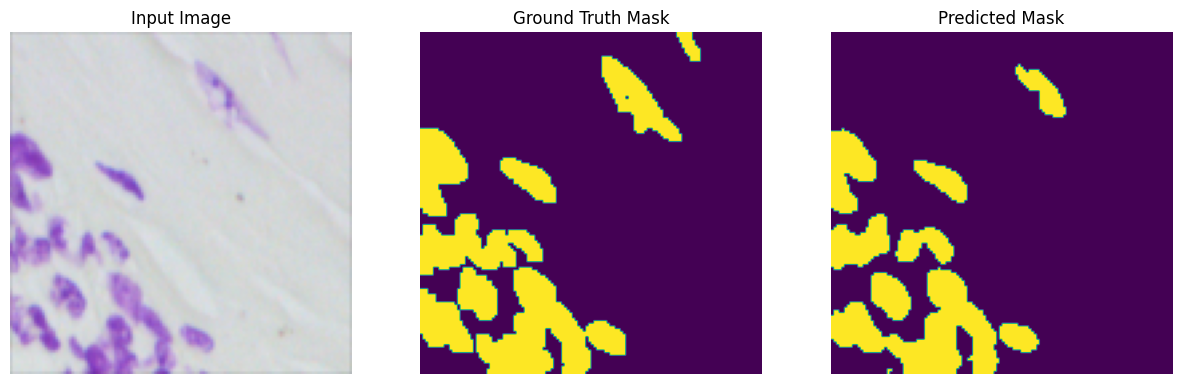

In [ ]:
ix = random.randint(0, len(train_preds))

def display_image(img1, img2, img3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Input Image')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('Predicted Mask')
    plt.show()

display_image(X_train[ix], np.squeeze(Y_train[ix]), np.squeeze(train_preds[ix]))

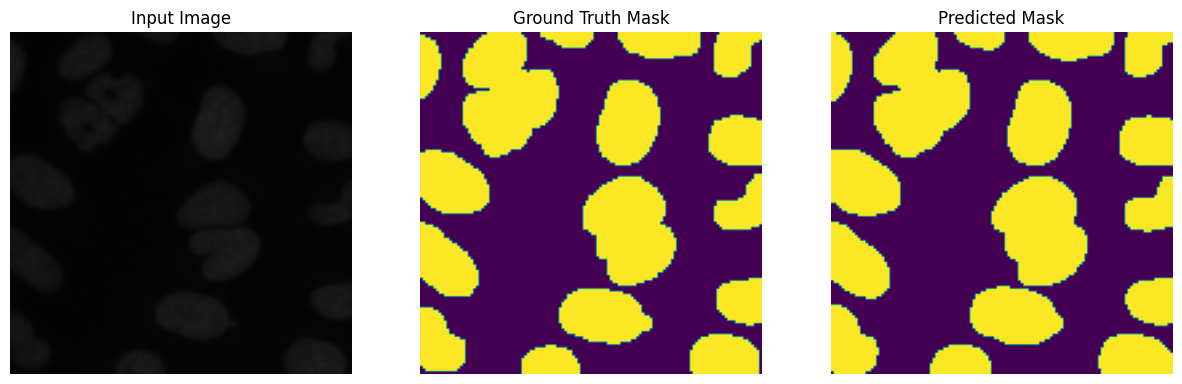

In [ ]:
ix = random.randint(0, len(val_preds))

def display_image(img1, img2, img3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Input Image')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('Predicted Mask')
    plt.show()

display_image(X_val[ix], np.squeeze(Y_val[ix]), np.squeeze(val_preds[ix]))

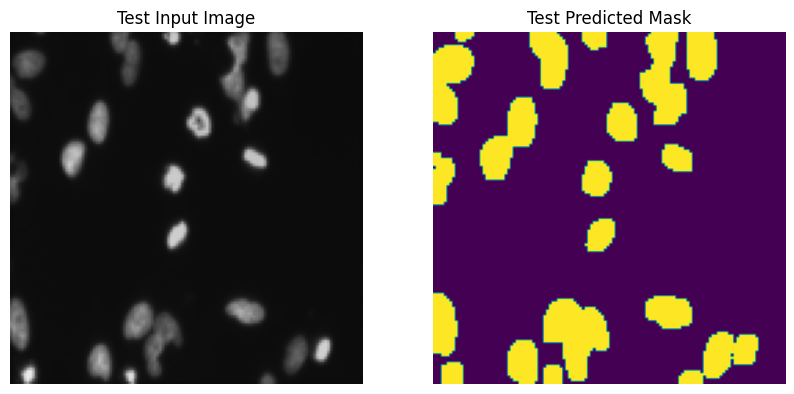

In [ ]:
ix = random.randint(0, len(test_preds))

def display_image(img1, img2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Test Input Image')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Test Predicted Mask')
    plt.show()

display_image(X_test[ix], np.squeeze(test_preds[ix]))